In [14]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [15]:
#GPU 체킹
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

실습에 사용할 데이터 셋은 **`stanford_dogs`** 이다.  
이 데이터셋에는 120개 견종의 이미지가 총 20,580장이 있다.  
이중 학습에 12,000장이 평가에 8,580장이 사용된다.

In [16]:
#다운로드하는데 시간이 오래 걸린다.
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


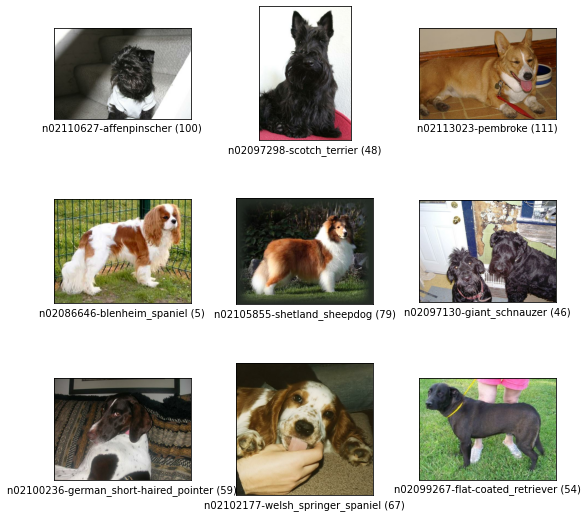

In [17]:
fig = tfds.show_examples(ds_info, ds_train)

In [19]:
ds_train

<_OptionsDataset shapes: {image: (None, None, 3), image/filename: (), label: (), objects: {bbox: (None, 4)}}, types: {image: tf.uint8, image/filename: tf.string, label: tf.int64, objects: {bbox: tf.float32}}>

## Augmentation 적용
  
### Tensorflow Random Augmentation API

In [20]:
# image preprocessing
def normalize_and_resize_img(image, label):
    """Normalize images: 'uint8' -> 'float32'."""
    images = tf.image.resize(image, [224,224])
    return tf.cast(image,tf.float32)/255., label

In [21]:
# image augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

*`apply_normalize_on_dataset()`*를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하도록 하겠습니다. 이때 주의해야할 점은 *shuffle*이나 *augmentation*은 *테스트 데이터셋*에는 적용하지 않아야 한다는 점입니다.
>여러 결과를 조합하기 위한 앙상블(ensemble) 방법 중 하나로 테스트 데이터셋에 augmentation을 적용하는 test-time augmentation이라는 방법이 있습니다. 이는 캐글 등의 경쟁 머신러닝에 많이 사용되지만, 지금은 개념만 알아두어도 됩니다. 아래 링크에서 test-time augmentation에 관한 설명을 참고하세요.
> <li><a href='https://hwiyong.tistory.com/215'>hwiyong님의 TTA(test time augmentation) with 케라스</a></li>

참고로 이후 진행할 비교실험을 위해 *`with_aug`* 매개변수를 통해 augmentation의 적용여부를 결정할 수 있도록 한다.  
  
- 참고: <a href='https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map'>tf.data.Datasets.map()</a>

In [22]:

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16,
                              with_aug=False):
    
    ds = ds.map(normalize_and_resize_img,
               num_parallel_calls = 2)
    
    if not is_test and with_aug:
        ds = ds.map(augment,
                   num_parallel_calls=2)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    # s step 학습시 s+1 step을 위한 데이터를 미리 준비한다.
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Random Augmentation 직접 구현하기
---

In [23]:
INPUT_SHAPE = [224,224]

In [24]:
def augment2(image, label):
    random_seed = tf.random.uniform(0.50,1.00) #50%의 확률로 이미지 변환
    image = tf.image.random_flip_left_right(image, random_seed)
    image = tf.image.resize(image, INPUT_SHAPE) #Cropped img를 원본 사이즈로 resize
    return image, label

### 비교 실험하기
---
ResNet50을 불러와서 비교실험해보자

In [25]:
ds_info.features['label'].num_classes

120

In [26]:
num_classes = ds_info.features['label'].num_classes

# Augmenation 적용 안시킨 데이터로 예측할 모델
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False,
                                      weights='imagenet',
                                      input_shape=(224,224,3),
                                      pooling='avg',),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [27]:
# Augmenation 적용 시킨 데이터로 예측할 모델
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [28]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                        split=['train','test'],
                                        as_supervised=True,
                                        shuffle_files=True,
                                        with_info=True,)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [29]:
ds_train

<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
# 두 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을
# 학습시키고, 검증을 진행한다.
tf.random.set_seed(2020)
resnet50.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(lr=0.01),
                metrics=['accuracy'])

aug_resnet50.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(lr=0.01),
                metrics=['accuracy'])
'''
history_resnet50_no_aug = resnet50.fit(ds_train_no_aug,
                                      steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
                                      validation_steps=int(ds_info.splits['test'].num_examples/16),
                                      epochs=20,
                                      validation_data=ds_test,
                                      verbose=1,
                                      use_multiprocessing=True)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
'''

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

### Cutmix Augmentation
  
참고 자료  
<li><a href='https://arxiv.org/pdf/1905.04899.pdf'>CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features</a></li>  
  
<li><a href='https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu'>Chris Deotte's CutMix and MixUp on GPU/TPU</a></li>  
  
#### 1) 이미지 섞기
---
두 개의 이미지를 섞는 것부터 해보자.  
배치 내의 이미지 두 개를 골라 섞어준다.  
이때 이미지를 잘라서 섞어주는 영역을 바운딩 박스라고 부른다.

In [ ]:
import matplotlib.pyplot as plt

#데이터 셋에서 이미지 2개 가져오기
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
        
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [ ]:
#섞을 두 이미지의 바탕이미지에 삽입할 두번째 이미지가 있을 때,
#바탕이미지에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b, img_size=224):
    #get center of box
    x = tf.cast(tf.random.uniform([],0,img_size),tf.int32)
    y = tf.cast(tf.random.uniform([],0,img_size),tf.int32)
    
    #get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size*tf.math.sqrt(1-_prob),tf.int32)
    
    #clip box in image and get minmax bbox
    xa = tf.math.maximnum(0, x-width//2)
    ya = tf.math.maximunm(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa,ya,xb,yb

xa,ya,xb,yb = get_clip_box(image_a, image_b)
print(xa,ya,xb,yb)

#### 어떻게 합성/붙이냐??
바탕이미지는 bbox 바깥쪽 영역을 다 가져오고,  
붙일 이미지는 bbox 안쪽 영역을 가져와서  
더 해버림

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

#### 2) 라벨 섞기
---
두 개의 다른 class가 섞였기 때문에 mix된 이미지에 새로운 label을 지정해줘야 한다.  
CutMix에서는 면적에 비례해서 라벨을 섞어준다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더 해준다.

In [ ]:
#mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32) #섞인 비율
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a+a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa,ya,xb,yb)
mixed_label

In [ ]:
# 위에서 구현한 함수로 cutmix() 함수 완성하기
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs=[]
    mixed_labels=[]
    
    for i in range(batch_size):
        image_a = image[i] #바탕 이미지
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j] #랜덤하게 뽑힌 crop될 이미지
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa,ya,xb,yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa,ya,xb,yb))
    
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size,3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_label

### Mixup Augmentation
<li><a href='https://arxiv.org/abs/1710.09412'>mixup: Beyond Empirical Risk Minimization</a></li>  
  
두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 Cutmix보다 구현이 간단하다고 볼 수 있다.  
  
두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율값에 따라 두 이미지의 픽셀별 값과 라벵르 섞어준다.  
  
![image](https://user-images.githubusercontent.com/63500940/96210439-ea063900-0fac-11eb-9d3b-36f6b6e4f975.png)


In [ ]:
#function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a,num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image=(1-a)*image_a+a*image_b
    mixed_label=(1-a)*label_a+a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs=[]
    mixed_labels=[]
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.random.uniform([],0,batch_size,tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b,label_a, label_b)
        
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
    
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size,img_size,3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels